# Convolutional: Instant Recognition with Caffe


### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook|
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.


* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [3]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/DCGAN_mnist/deploy_DCGAN_train_val.prototxt'
model_weights = caffe_root + 'models/DCGAN_mnist/models/_iter_12000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [4]:

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
#transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]

### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [5]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(32,        # batch size
                          1,         # 1-channel images
                          32, 32)  # image size is 32*32

In [ ]:
net.forward()
plt.imshow(net.blobs['data'].data[:8, 0].transpose(2, 0, 1).reshape(32, 8*32)); plt.axis('off')
print 'train labels:', net.blobs['label'].data[:8]


* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

In [ ]:
image = caffe.io.load_image(caffe_root + 'models/DCGAN_mnist/0.png')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

* Adorable! Let's classify it!

In [ ]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image.reshape(3,1,32,32) # reshape the imagedata and fit int the network input

### perform classification
output = net.forward()

#output_prob = output['loss']  # the output probability vector for the first image in the batch

#print 'predicted class is:', output_prob.argmax()

* The net gives us a vector of probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels...

### 5. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [6]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data); plt.axis('off')
    plt.imsave('generated.png',data)


* First we'll look at the first layer filters, `conv1`

In [ ]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
#print filters.shape
vis_square(filters)

* The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

(1, 32, 32)


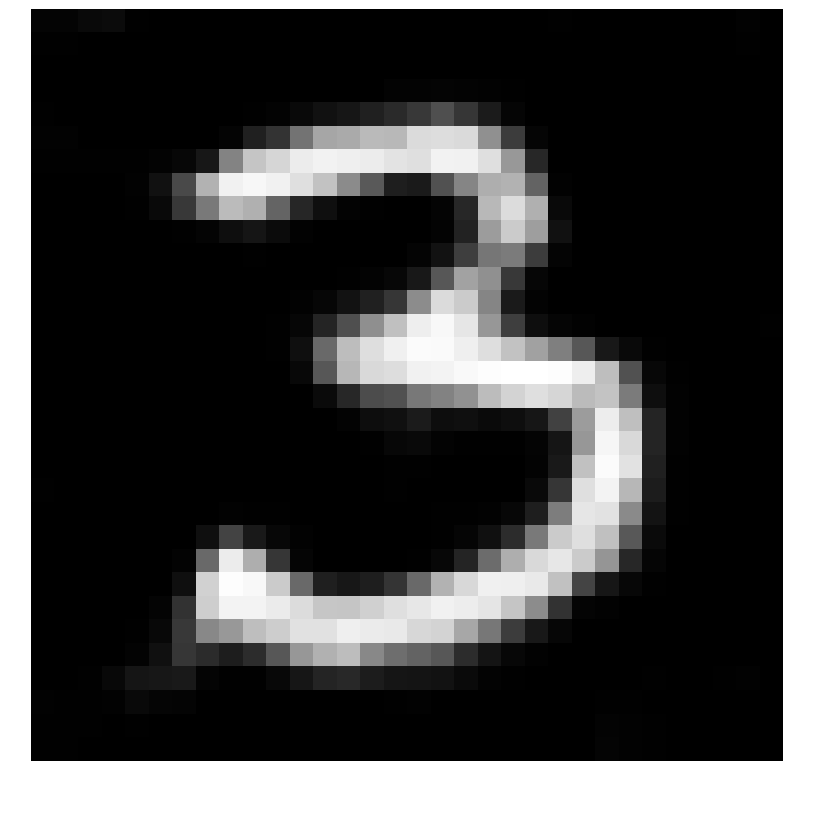

In [7]:
output = net.forward()
feat = net.blobs['gen_conv4'].data[0]
print feat.shape
vis_square(feat)

(32, 16, 16)


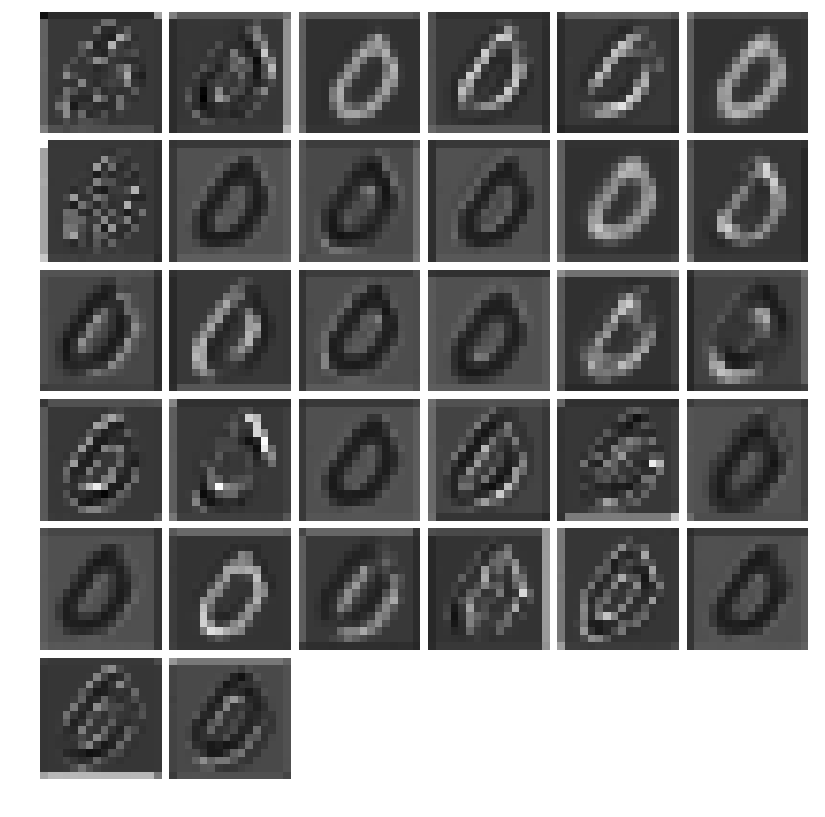

In [8]:
output = net.forward()
feat = net.blobs['dis_conv_d1'].data[0]
print feat.shape
vis_square(feat)

* The fifth layer after pooling, `pool5`

(-0.5, 511.5, 31.5, -0.5)

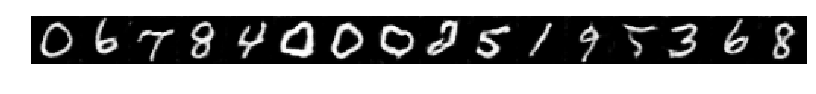

In [10]:
output = net.forward()
feat = net.blobs['gen_conv4'].data[:16,0]
#vis_square(feat)
plt.imshow(feat.transpose(1, 0, 2).reshape(32, 16*32), cmap='gray'); plt.axis('off')

* The first fully connected layer, `fc6` (rectified)

    We show the output values and the histogram of the positive values

In [11]:
one_hot = net.blobs['encode'].data[:]
label = net.blobs['label'].data[:]
print label
print one_hot

[ 0.  6.  7.  8.  4.  0.  0.  0.  2.  5.  1.  9.  5.  3.  6.  8.  1.  3.
  9.  8.  0.  6.  6.  8.  3.  5.  8.  2.  8.  9.  2.  9.]
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.

In [33]:
concat_code = net.blobs['concat_code'].data[0]
print concat_code

[ 0.          1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.64189994 -0.68089998  0.63890004
  0.48689997  0.43939996 -0.32489997 -0.7155      0.51440001 -0.10939997
 -0.91320002 -0.72799999  0.33589995  0.30439997 -0.98729998  0.57630002
 -0.27969998  0.8829     -0.90530002  0.71319997  0.43789995  0.21159995
  0.14160001 -0.28119999  0.71679997 -0.5341      0.35350001  0.96990001
  0.57350004  0.07459998  0.63849998  0.37609994 -0.78049999 -0.1092
  0.86380005  0.62779999  0.28429997 -0.29759997 -0.95819998  0.7493
 -0.78640002 -0.56630003  0.85899997 -0.96829998  0.44379997 -0.17330003
 -0.77240002  0.33080006 -0.2791     -0.25980002 -0.33499998  0.52750003
 -0.36979997  0.40890002 -0.53380001  0.58899999  0.46150005  0.59490001
  0.77830005  0.40460002  0.55309999  0.76730001  0.94309998  0.98769999
 -0.10530001 -0.64320004  0.63039994  0.40320003  0.28100002 -0.31660002
  0.74070001 -0.79210001 -0.88679999  0.76010001  0.674

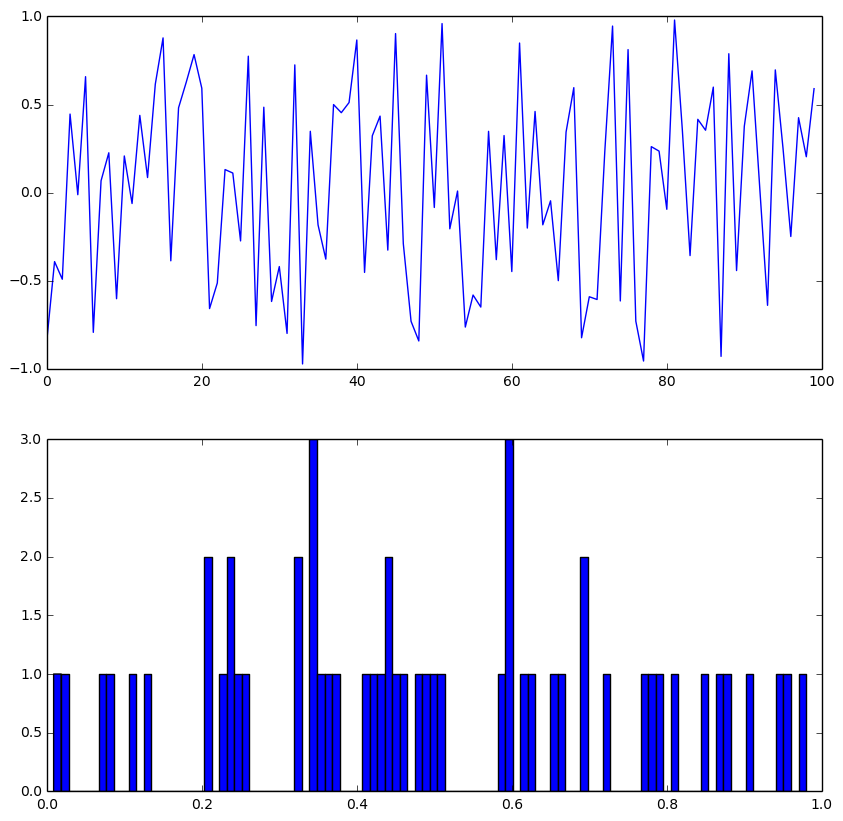

In [101]:
#print net.params['ip1encode'][0].data
feat = net.blobs['rand_vec'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

In [ ]:
feat = net.blobs['fc6decode'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

* The final probability output, `prob`

In [ ]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

### 6. Extract the feature

To extract deepfeature 

In [ ]:
#load the net and set caffe model
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
caffe.set_mode_cpu()

model_def = caffe_root + 'models/CAE_mvco/CAE_vgg_train_val.prototxt'
model_weights = caffe_root + 'models/CAE_mvco/_iter_120000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# perform classification
f = open('feature.txt', "a+")
iteration = 2
for a in range(0,iteration):
    net.forward()
    f.write(net.blobs['fc6decode'].data[0])